## **zebrafish dataset preprocessing** ##

In [1]:
import scvelo as scv
import numpy as np
from anndata import AnnData
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from scipy.cluster.hierarchy import fcluster,leaders
from sklearn.decomposition import PCA
from scipy.linalg import inv
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.mixture import GaussianMixture
from scipy.stats import multivariate_normal
from scipy.sparse import csr_matrix,issparse
import pandas as pd
import seaborn as sns
import scanpy as sc

import argparse
import random

import scipy.sparse as sp
import scipy.sparse.csgraph
import sklearn.linear_model as sklm
import sklearn.metrics as skm
import sklearn.model_selection as skms
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

CHECKPOINT_PREFIX = "g2g"

from utils import *
# from minepy import MINE
from sklearn.preprocessing import MinMaxScaler

print(torch.__version__)
print(torch.version.cuda)
print(torch.cuda.is_available())
print(torch.cuda.device_count())

method = ''
from g2g_model_Fisher import *

data_path='data/'
result_path='encoder/'

data_path = 'data/'
# data_name = 'DG_bin'
# data_name = 'DG_new'
# data_name = 'A549_emt_bin'
data_name = 'zebrafish_dynamo'
# data_name = 'neural_bin'
# adata0 = scv.read(data_path+data_name+'.h5ad', cache=True)
adata0 = scv.read(data_path+data_name+'.h5ad', cache=True)

# [k_nei, K] = [10, 4]
# L = np.load('results/'+data_name+','+method+'/'+str([k_nei,K])+',latent_dim.npy')
[k_nei, K, L] = [30, 2, 10]
# metric = 'minkowski'
metric = 'euclidean'
# metric = 'cosine'
# metric = 'correlation'
norm = 'none'
# norm = 'standard'
# norm = 'minmax'

result_path = 'results/'+data_name+','+norm+','+metric+','+method+','+str([k_nei,K,L])+'/'
figure_path = 'figures/'
cmap = plt.colormaps['Spectral']

import os

folder = os.path.exists(result_path)
if not folder:                   #判断是否存在文件夹如果不存在则创建为文件夹
    os.makedirs(result_path)            #makedirs 创建文件时如果路径不存在会创建这个路径

adata0

2.3.1+cpu
None
False
0


AnnData object with n_obs × n_vars = 4181 × 16940
    obs: 'split_id', 'sample', 'Size_Factor', 'condition', 'Cluster', 'Cell_type', 'umap_1', 'umap_2', 'batch'
    layers: 'spliced', 'unspliced'

## **Preprocessing for Zebrafish from Dynamo** ##

In [2]:
# filter, normalize total counts and log-transform
adata=adata0.copy()
sc.pp.filter_genes(adata, min_cells=10)
scv.pp.normalize_per_cell(adata)
sc.pp.log1p(adata)

# hvg
sc.pp.highly_variable_genes(adata,n_top_genes=600)
print(f"This detected {adata.var['highly_variable'].sum()} highly variable genes. ")

Normalized count data: X, spliced, unspliced.
This detected 600 highly variable genes. 


In [3]:
adata = adata[:,np.array(adata.var['highly_variable'].tolist()) == True]
adata

View of AnnData object with n_obs × n_vars = 4181 × 600
    obs: 'split_id', 'sample', 'Size_Factor', 'condition', 'Cluster', 'Cell_type', 'umap_1', 'umap_2', 'batch', 'n_counts'
    var: 'n_cells', 'gene_count_corr', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'
    layers: 'spliced', 'unspliced'

In [4]:
# remove duplicate cells
sc.pp.neighbors(adata, n_neighbors=k_nei)
scv.pp.remove_duplicate_cells(adata)
scv.pp.moments(adata, n_pcs=30, n_neighbors=k_nei)
adata

Removed 37 duplicate cells.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


AnnData object with n_obs × n_vars = 4144 × 600
    obs: 'split_id', 'sample', 'Size_Factor', 'condition', 'Cluster', 'Cell_type', 'umap_1', 'umap_2', 'batch', 'n_counts'
    var: 'n_cells', 'gene_count_corr', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'spliced', 'unspliced', 'Ms', 'Mu'
    obsp: 'distances', 'connectivities'

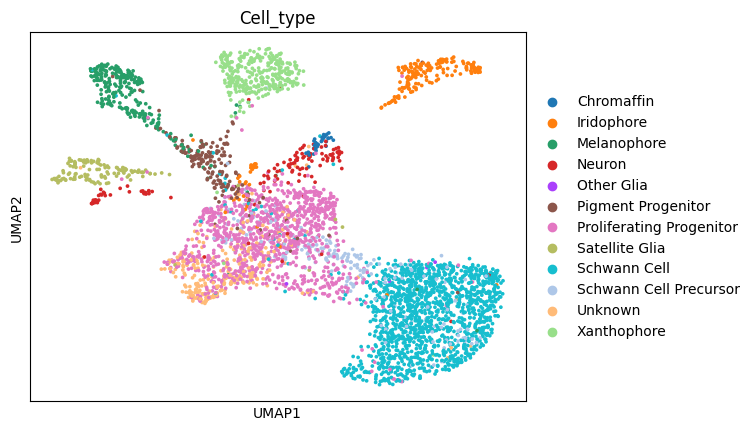

In [5]:
sc.tl.umap(adata)
fig = sc.pl.embedding(
    adata,
    color = ["Cell_type"],
    basis = "umap",
    color_map = "gnuplot2",
    return_fig = True
)
fig.savefig(result_path+'stage')

In [6]:
# remove Chromaffin, Iridophore, Neuron, Satellite Glia, Unkown
idx = ~((np.array(adata.obs['Cell_type'].tolist()) == 'Iridophore') + (np.array(adata.obs['Cell_type'].tolist()) == 'Satellite Glia') + (np.array(adata.obs['Cell_type'].tolist()) == 'Neuron') + (np.array(adata.obs['Cell_type'].tolist()) == 'Unknown') + (np.array(adata.obs['Cell_type'].tolist()) == 'Chromaffin'))

adata = adata[idx]
adata

View of AnnData object with n_obs × n_vars = 3386 × 600
    obs: 'split_id', 'sample', 'Size_Factor', 'condition', 'Cluster', 'Cell_type', 'umap_1', 'umap_2', 'batch', 'n_counts'
    var: 'n_cells', 'gene_count_corr', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'Cell_type_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'spliced', 'unspliced', 'Ms', 'Mu'
    obsp: 'distances', 'connectivities'

In [7]:
sc.write('data/zebrafish_dynamo_part.h5ad',adata)